In [ ]:
#https://github.com/CortexFoundation/StyleTransferTrilogy

In [1]:
import tensorflow as tf
from matplotlib import pyplot as plt
from PIL import Image
import numpy as np
import cv2
import scipy.io as sio

#模型
import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import numpy as np
from collections import defaultdict

#from utils import *

In [16]:
## 读入图片，并转为浮点数组，且减去128.0，以0为中心，加快收敛速度
style = Image.open('/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/star.jpg')
style = style.resize((224,224),Image.ANTIALIAS)
style = np.array(style)
style = style.reshape(-1,3,224,224)
style = style.astype(np.float32) - 128.0

content = Image.open('/home/liuzixuan/实训/02-用Python快速实现图片的风格迁移/img/img02.jpg')
content = content.resize((224,224),Image.ANTIALIAS)
content = np.array(content)
content = content.reshape(-1,3,224,224)
content = content.astype(np.float32) - 128.0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


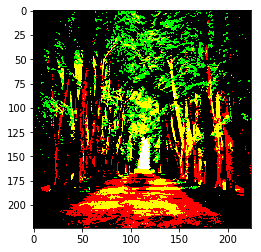

In [3]:
plt.imshow(content)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


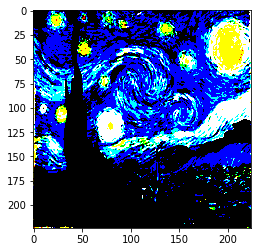

In [4]:
plt.imshow(style)

In [7]:
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
class VGG(nn.Module):

    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.layer_name_mapping = {
            '3': "relu1_2",
            '8': "relu2_2",
            '15': "relu3_3",
            '22': "relu4_3"
        }
        for p in self.parameters():
            p.requires_grad = False
    
    def forward(self, x):
        outs = []
        for name, module in self.features._modules.items():
            x = module(x)
            if name in self.layer_name_mapping:
                outs.append(x)
        return outs
vgg16 = models.vgg16(pretrained=True)
vgg16 = VGG(vgg16.features[:23])

In [17]:
ｓｔｙｌｅ = torch.from_numpy(style)
content = torch.from_numpy(content)

In [18]:
print(style.shape)

torch.Size([1, 3, 224, 224])


In [21]:
style_features = vgg16(style)
content_features = vgg16(content)

In [23]:
class ContentLoss(nn.Module): 
    def __init__(self, target, weight): 
        super(ContentLoss, self).__init__() 
        # we 'detach' the target content from the tree used 
        self.target = target.detach() * weight 
        # to dynamically compute the gradient: this is a stated value, 
        # not a variable. Otherwise the forward method of the criterion 
        # will throw an error. 
        self.weight = weight 
        self.criterion = nn.MSELoss() 
        
    def forward(self, input): 
        self.loss = self.criterion(input * self.weight, self.target) 
        self.output = input 
        return self.output 
    def backward(self, retain_graph=True): 
        self.loss.backward(retain_graph=retain_graph) 
        return self.loss
class GramMatrix(nn.Module): 
    def forward(self, input): 
        a, b, c, d = input.size() # a=batch size(=1) 
        # b=number of feature maps 
        # (c,d)=dimensions of a f. map (N=c*d) 
        features = input.view(a * b, c * d) # resise F_XL into \hat F_XL 
        G = torch.mm(features, features.t()) # compute the gram product 
        # we 'normalize' the values of the gram matrix 
        # by dividing by the number of element in each feature maps.
        return G.div(a * b * c * d)
class StyleLoss(nn.Module): 
    def __init__(self, target, weight): 
        super(StyleLoss, self).__init__() 
        self.target = target.detach() * weight 
        self.weight = weight 
        self.gram = GramMatrix() 
        self.criterion = nn.MSELoss() 
    def forward(self, input): 
        self.output = input.clone() 
        self.G = self.gram(input) 
        self.G.mul_(self.weight) 
        self.loss = self.criterion(self.G, self.target) 
        return self.output 
    def backward(self, retain_graph=True): 
        self.loss.backward(retain_graph=retain_graph) 
        return self.loss

In [ ]:
input_img = content_img.clone()
optimizer = optim.LBFGS([style.requires_grad_()])
style_weight = 1e6
content_weight = 1

run = [0]
while run[0] <= 300:
    def f():
        optimizer.zero_grad()
        features = vgg16(input_img)
        
        content_loss = F.mse_loss(features[2], content_features[2]) * content_weight
        style_loss = 0
        grams = [gram_matrix(x) for x in features]
        for a, b in zip(grams, style_grams):
            style_loss += F.mse_loss(a, b) * style_weight
        
        loss = style_loss + content_loss
        
        if run[0] % 50 == 0:
            print('Step {}: Style Loss: {:4f} Content Loss: {:4f}'.format(
                run[0], style_loss.item(), content_loss.item()))
        run[0] += 1
        
        loss.backward()
        return loss
    
    optimizer.step(f)